In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import linear_model as lm
from sklearn import svm
import sklearn.neural_network as nn
from sklearn import ensemble as en
from sklearn import neighbors as nb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

import splashback as sp

In [2]:
#read in data
macsis = sp.macsis()
macsis.read_morphologies()
#ceagle = sp.ceagle()

N_macsis = 390
N_ceagle = 30

N_bins = 40
log_radii = np.linspace(-1, 0.6, N_bins+1)
rad_mid = (10**log_radii[1:] + 10**log_radii[:-1]) / 2

In [3]:
macsis.RSP_DM = sp.R_SP_finding(rad_mid, macsis.DM_density_3D)
#macsis.RSP_gas = sp.R_SP_finding(rad_mid, macsis.gas_density_3D)
#macsis.RSP_star = sp.R_SP_finding(rad_mid, macsis.star_density_3D)

In [4]:
#calculate splashback radii in 2D
macsis.RSP_WL = sp.R_SP_finding(rad_mid, macsis.DM_median)
macsis.RSP_EM = sp.R_SP_finding(rad_mid, macsis.EM_median)
macsis.RSP_SD = sp.R_SP_finding(rad_mid, macsis.SD_median)
macsis.RSP_SZ = sp.R_SP_finding(rad_mid, macsis.SZ_median)

#ceagle.RSP_WL = sp.R_SP_finding(rad_mid, ceagle.DM_median)
#ceagle.RSP_EM = sp.R_SP_finding(rad_mid, ceagle.EM_median)
#ceagle.RSP_SD = sp.R_SP_finding(rad_mid, ceagle.SD_median)
#ceagle.RSP_SZ = sp.R_SP_finding(rad_mid, ceagle.SZ_median)

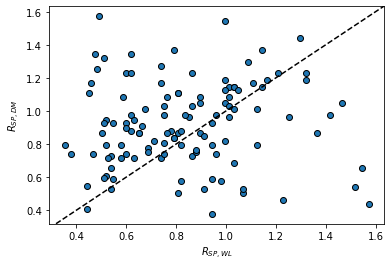

-1.1287656964328976


In [5]:
plt.figure()
plt.scatter(macsis.RSP_WL[:117], macsis.RSP_DM[:117], edgecolor="k") #first 117 to match number above
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plt.plot(ylim, ylim, linestyle="--", color="k")
plt.ylim(ylim)
plt.xlim(xlim)
plt.xlabel("$R_{SP, WL}$")
plt.ylabel("$R_{SP, DM}$")
plt.show()
print(metrics.r2_score(macsis.RSP_DM[:117], macsis.RSP_WL[:117])) #not really fair to use this method on this data
#should use a statistic that can be used on both the fits and the 2D v 3D data

In [6]:
#read in shape data about clusters
#radii = np.linspace(0.5, 1.5, 10) #for reference
ellipticity_x = np.genfromtxt("splashback_data/macsis/ellipticity_profiles_x_macsis.csv", delimiter=",")
ellipticity_y = np.genfromtxt("splashback_data/macsis/ellipticity_profiles_y_macsis.csv", delimiter=",")
ellipticity_z = np.genfromtxt("splashback_data/macsis/ellipticity_profiles_z_macsis.csv", delimiter=",")

substructure_x = np.genfromtxt("splashback_data/macsis/substructure_profiles_x_macsis.csv", delimiter=",")
substructure_y = np.genfromtxt("splashback_data/macsis/substructure_profiles_y_macsis.csv", delimiter=",")
substructure_z = np.genfromtxt("splashback_data/macsis/substructure_profiles_z_macsis.csv", delimiter=",")

ellipticity = np.vstack((ellipticity_x, ellipticity_y, ellipticity_z))
substructure = np.vstack((substructure_x, substructure_y, substructure_z))



In [7]:
X_RSP = np.vstack((macsis.RSP_WL, macsis.RSP_EM, macsis.RSP_SD, macsis.RSP_SZ)).T
X_profiles = np.hstack((macsis.DM_median, macsis.EM_median, macsis.SD_median, macsis.SZ_median))
X_morph = np.vstack((macsis.concentration, macsis.symmetry, macsis.alignment, macsis.centroid)).T
X = np.hstack((X_RSP, X_morph, ellipticity, substructure))

y = np.hstack((macsis.RSP_DM, macsis.RSP_DM, macsis.RSP_DM)) #be careful about repeat results

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
kf = KFold(n_splits=10, shuffle=True)

In [38]:
OLR = lm.LinearRegression()
scatter_OLR = cross_val_score(OLR, X, y, cv=kf, scoring='neg_mean_squared_error')
mean_OLR = np.mean(scatter_OLR)
std_OLR = np.std(scatter_OLR)
print(mean_OLR, std_OLR)

-0.08744906827719305 0.010577186526040689


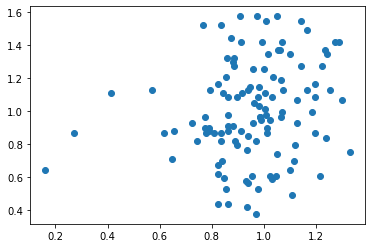

In [39]:
OLR = OLR.fit(X_train, y_train)
y_predict = OLR.predict(X_test)
plt.scatter(y_predict, y_test)
plt.show()

In [40]:
RR = lm.Ridge()
scatter_RR = cross_val_score(RR, X, y, cv=kf, scoring='neg_mean_squared_error')
mean_RR = np.mean(scatter_RR)
std_RR = np.std(scatter_RR)
print(mean_RR, std_RR)

-0.08112746885390333 0.016887940587242273


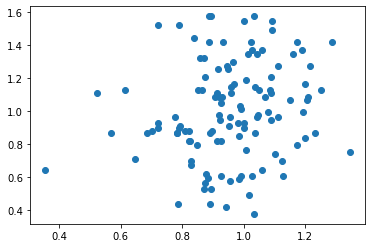

In [41]:
RR = RR.fit(X_train, y_train)
y_predict = RR.predict(X_test)
plt.scatter(y_predict, y_test)
plt.show()

In [42]:
Lss = lm.Lasso(alpha=0.15)
scatter_Lss = cross_val_score(Lss, X, y, cv=kf, scoring='neg_mean_squared_error')
mean_Lss = np.mean(scatter_Lss)
std_Lss = np.std(scatter_Lss)
print(mean_Lss, std_Lss)

-0.07649955927759028 0.012758874465401035


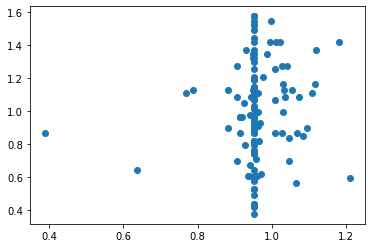

In [43]:
Lss = Lss.fit(X_train, y_train)
y_predict = Lss.predict(X_test)
plt.scatter(y_predict, y_test)
plt.show()

In [44]:
kNN = nb.KNeighborsRegressor(n_neighbors=9, weights="distance")
scatter_kNN = cross_val_score(kNN, X, y, cv=kf, scoring='neg_mean_squared_error')
mean_kNN = np.mean(scatter_kNN)
std_kNN = np.std(scatter_kNN)
print(mean_kNN, std_kNN)

-0.08164230153169166 0.005939408038985885


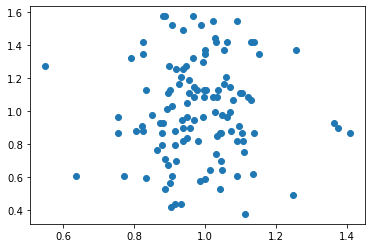

-0.18332915582614318


In [45]:
kNN = kNN.fit(X_train, y_train)
y_predict = kNN.predict(X_test)
plt.scatter(y_predict, y_test)
plt.show()
print(metrics.r2_score(y_test, y_predict))

In [46]:
DTreg = tree.DecisionTreeRegressor(max_depth=15)
kf = KFold(n_splits=10, shuffle=True)

scatter_DTreg = cross_val_score(DTreg, X, y, cv=kf, scoring='neg_mean_squared_error')
mean_DTreg = np.mean(scatter_DTreg)
std_DTreg = np.std(scatter_DTreg)
print(mean_DTreg, std_DTreg)

-0.13042345539870212 0.02078512386299163


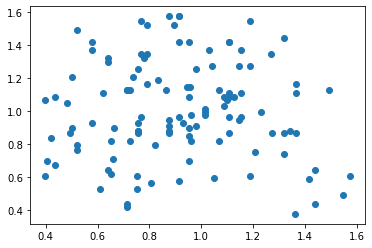

-1.0658573886324434


In [47]:
DTreg = DTreg.fit(X_train, y_train)
y_predict = DTreg.predict(X_test)
plt.scatter(y_predict, y_test)
plt.show()
print(metrics.r2_score(y_test, y_predict))

In [48]:
GBDT = en.GradientBoostingRegressor(max_depth=5)
scatter_GBDT = cross_val_score(GBDT, X, y, cv=kf, scoring='neg_mean_squared_error')
mean_GBDT = np.mean(scatter_GBDT)
std_GBDT = np.std(scatter_GBDT)
print(mean_GBDT, std_GBDT)

-0.06863440180862357 0.008163566988435738


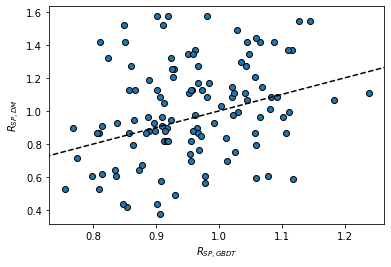

0.06229381777494036


In [49]:
GBDT = GBDT.fit(X_train, y_train)
y_predict = GBDT.predict(X_test)
plt.scatter(y_predict, y_test, edgecolor="k")
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plt.plot(ylim, ylim, linestyle="--", color="k")
plt.ylim(ylim)
plt.xlim(xlim)
plt.xlabel("$R_{SP, GBDT}$")
plt.ylabel("$R_{SP, DM}$")
plt.show()
print(metrics.r2_score(y_test, y_predict))

In [50]:
RF = en.RandomForestRegressor()
scatter_RF = cross_val_score(RF, X, y, cv=kf, scoring='neg_mean_squared_error')
mean_RF = np.mean(scatter_RF)
std_RF = np.std(scatter_RF)
print(mean_RF, std_RF)

-0.06590724775920656 0.009303030167359947


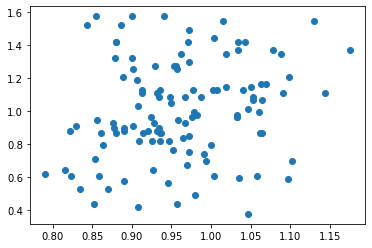

0.014176631715249743


In [51]:
RF = RF.fit(X_train, y_train)
y_predict = RF.predict(X_test)
plt.scatter(y_predict, y_test)
plt.show()
print(metrics.r2_score(y_test, y_predict))

In [13]:
# Create the RFE object and compute a cross-validated score.
rf = en.RandomForestRegressor()
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 5  # Minimum number of features to consider
#rfecv = RFE(
#    estimator=rf,
#    step=1,
#    n_features_to_select=min_features_to_select,
#)

rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=kf,
    scoring='neg_mean_squared_error',
    min_features_to_select=min_features_to_select,
)
#print("Optimal number of features : %d" % rfecv.n_features_)

scatter_RF = cross_val_score(rfecv, X, y, cv=kf, scoring='neg_mean_squared_error')
mean_RF = np.mean(scatter_RF)
std_RF = np.std(scatter_RF)
print(mean_RF, std_RF)

-0.06871823523209401 0.008071809616709382


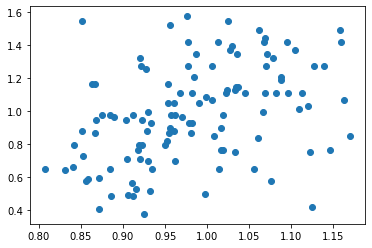

0.15142829575078154


In [14]:
rfecv = rfecv.fit(X_train, y_train)
y_predict = rfecv.predict(X_test)
plt.scatter(y_predict, y_test)
plt.show()
print(metrics.r2_score(y_test, y_predict))